In [1]:
#This notebook details the data preprocessing pipeline I used. 
#This isn't very formalized as I quite often went back and form in a data
#exploratory way in order to figure out the right order of precedence.

import pickle
import preprocessing
import pandas as pd
import nltk
import re
import data_formatting

from joblib import Parallel, delayed
import os
import numpy as np

import seaborn as sns
import string

def chunkPickleSave(data, save_path, chunks):
    chunk_size = int(len(data)/chunks)
    print (chunk_size)
    for i in range(chunks):
        
        if i != chunks-1:
            data[i*chunk_size:(i+1)*chunk_size].to_pickle(save_path + '_part_%d.pkl' % i)
        
        else:
            data[i*chunk_size:].to_pickle(save_path + '_part_%d.pkl' % i)

def chunkPickleLoad(load_path, file_wildcard):
    
    df = pd.DataFrame()
    
    files = [i for i in os.listdir(load_path) if file_wildcard in i]
    
    for idx, i in enumerate(files):
        #if idx>2: break

        if idx==0:
            df = pd.read_pickle(load_path + '/' + i)
            df = df[[pair_0, 'n_' + pair_0, pair_1, 'n_' + pair_1]]
        else:
            df_temp = pd.read_pickle(load_path + '/' + i)
            df_temp = df_temp[[pair_0, 'n_' + pair_0, pair_1, 'n_' + pair_1]]
            df = pd.concat([df, df_temp])
        
    return df   

def stripLineBreak(x):
    return x.replace('\n', '')

def createConversations(all_text):
    conv = [[all_text[idx_text], all_text[idx_text+1]] for idx_text, text in enumerate(all_text[:-1])]
    return conv

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#dataset = 'de_en'
#t_enc = open(r'C:\Users\euix\nmt_data\wmt16_de_en\train.en', 'r', encoding='utf8')
#t_dec = open(r'C:\Users\euix\nmt_data\wmt16_de_en\train.de', 'r', encoding='utf8')

#t_enc = t_enc.readlines()
#t_dec = t_dec.readlines()

In [ ]:
#Raw data is converted to a dataframe of two columns representing encoder and decoder inputs
dataset = 'twitter'
#twitter_data = open('../../datasets/chat.txt', 'r', encoding='utf-8')
twitter_data = open('../../datasets/chat_corpus/cleaned_corpus_en.txt', 'r', encoding='utf-8')

twitter_lines = twitter_data.readlines()

twitter_convs = [[line for idx, line in enumerate(twitter_lines) if idx%2==1], 
              [line for idx, line in enumerate(twitter_lines) if idx%2==0]]

df_all = pd.DataFrame(list(zip(*twitter_convs)), columns=['Pair_0', 'Pair_1']) 

In [ ]:
print ('rows of data', df_all.shape[0])

In [ ]:
#df_all = df_all.sample(frac=1, random_state=0)

In [ ]:
#Remove non-alphanumeric characters and strip any line breaks

df_all['Pair_0'] = df_all['Pair_0'].apply(preprocessing.remove_non_ascii)

df_all['Pair_1'] = df_all['Pair_1'].apply(preprocessing.remove_non_ascii)

df_all['Pair_0'] = df_all['Pair_0'].apply(stripLineBreak)

df_all['Pair_1'] = df_all['Pair_1'].apply(stripLineBreak)

In [6]:
#Check and remove all non-alphanumeric characters except end sentence chars (i.e. !, ?)
Pair_0_char_checked = Parallel(n_jobs=-1, verbose=8)(delayed(preprocessing.checkChars)(i) for i in df_all['Pair_0'].values)
Pair_1_char_checked = Parallel(n_jobs=-1, verbose=8)(delayed(preprocessing.checkChars)(i) for i in df_all['Pair_1'].values)

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 38733 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 170543 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 329253 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 509483 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 716613 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 945263 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 1200813 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 1477883 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 1781853 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 2107343 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 2459733 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 2601244 out of 2601244 | elapsed:   51.4s finished
[Parallel(n_jobs

In [7]:
df_all['Pair_0_char_checked'] = Pair_0_char_checked

df_all['Pair_1_char_checked'] = Pair_1_char_checked

In [8]:
Pair_0_char_checked = []
Pair_1_char_checked = []

In [9]:
#Word tokenize each sentence, count the length and append <EOS> char
alpha_Pair_0_tokens = Parallel(n_jobs=-1, verbose=8)(\
                            delayed(preprocessing.checkAlphaLower)(i) for i in df_all['Pair_0_char_checked'].values)

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 10887 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 40189 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 75471 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 115537 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 161583 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 212413 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 269223 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 330817 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 398391 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 470749 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 549087 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 632209 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 721311 ta

In [10]:
alpha_Pair_1_tokens = Parallel(n_jobs=-1, verbose=8)(\
                            delayed(preprocessing.checkAlphaLower)(i) for i in df_all['Pair_1_char_checked'].values)

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 9707 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 38911 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 74075 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 114007 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 159899 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 210559 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 267179 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 328567 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 395915 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 459389 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 498427 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 539849 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 584251 tas

In [11]:
df_all['alpha_Pair_0_tokens'] = list(zip(*alpha_Pair_0_tokens))[0]

df_all['alpha_Pair_1_tokens'] = list(zip(*alpha_Pair_1_tokens))[0]

In [12]:
df_all['n_alpha_Pair_0_tokens'] = list(zip(*alpha_Pair_0_tokens))[1]

df_all['n_alpha_Pair_1_tokens'] = list(zip(*alpha_Pair_1_tokens))[1]

In [13]:
alpha_Pair_0_tokens = []
alpha_Pair_1_tokens = []

In [14]:
#Strip rows that are now empty
df_all = df_all[df_all['n_alpha_Pair_0_tokens'] != 0]

df_all = df_all[df_all['n_alpha_Pair_1_tokens'] != 0]

In [15]:
#Stem word tokens
alpha_stem_Pair_0_tokens = Parallel(n_jobs=-1, verbose=8)(\
                            delayed(preprocessing.nltkStem)(i) for i in df_all['alpha_Pair_0_tokens'].values)

df_all['alpha_stem_Pair_0_tokens'] = list(zip(*alpha_stem_Pair_0_tokens))[0]
df_all['n_alpha_stem_Pair_0_tokens'] = list(zip(*alpha_stem_Pair_0_tokens))[1]

alpha_stem_Pair_1_tokens = Parallel(n_jobs=-1, verbose=8)(\
                            delayed(preprocessing.nltkStem)(i) for i in df_all['alpha_Pair_1_tokens'].values)

df_all['alpha_stem_Pair_1_tokens'] = list(zip(*alpha_stem_Pair_1_tokens))[0]

df_all['n_alpha_stem_Pair_1_tokens'] = list(zip(*alpha_stem_Pair_1_tokens))[1]

alpha_stem_quote_tokens = []
alpha_stem_quote_tokens = []

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 11260 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 49774 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 96148 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 148810 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 209332 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 276142 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 346096 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 386575 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 430984 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 478537 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 530020 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 584647 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 643204 ta

In [16]:
#Lemmatize tokens, note I am applying this separately to stemming, to further vocabulary one could apply stemming
#and lemmatization at the cost of comprehension

alpha_lem_Pair_0_tokens = Parallel(n_jobs=-1, verbose=8)(\
                            delayed(preprocessing.nltkLem)(i) for i in df_all['alpha_Pair_0_tokens'].values)

df_all['alpha_lem_Pair_0_tokens'] = list(zip(*alpha_lem_Pair_0_tokens))[0]
df_all['n_alpha_lem_Pair_0_tokens'] = list(zip(*alpha_lem_Pair_0_tokens))[1]

alpha_lem_Pair_1_tokens = Parallel(n_jobs=-1, verbose=8)(\
                            delayed(preprocessing.nltkLem)(i) for i in df_all['alpha_Pair_1_tokens'].values)

df_all['alpha_lem_Pair_1_tokens'] = list(zip(*alpha_lem_Pair_1_tokens))[0]

df_all['n_alpha_lem_Pair_1_tokens'] = list(zip(*alpha_lem_Pair_1_tokens))[1]

alpha_lem_quote_tokens = []
alpha_lem_quote_tokens = []

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 34554 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 105211 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 190588 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 289212 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 402556 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 527676 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 667516 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 819132 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 985468 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1078204 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1174620 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1276924 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1386

In [ ]:
chunkPickleSave(df_all, 
                '../../datasets/%s_preprocess_pickle_stage_0_sample_%d' % (dataset, df_all.shape[0]), 10)

In [5]:
processing_type='stem'
pair_0 = 'alpha_%s_Pair_0_tokens' % processing_type
pair_1 = 'alpha_%s_Pair_1_tokens' % processing_type

In [6]:
file_string = 'preprocess_pickle_stage_0_sample_2601244_part'

In [7]:
df_all = chunkPickleLoad('../../datasets/', file_string)

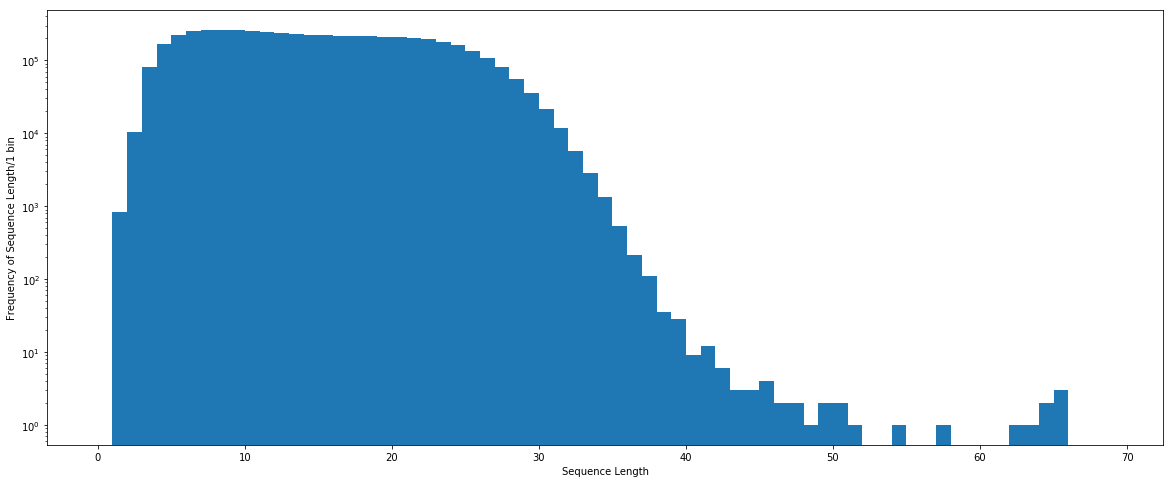

In [8]:
#Plot the distribution of sequence lengths
sent_lengths = sum([list(df_all['n_' + pair_0].values), \
                    list(df_all['n_' + pair_1].values)], [])
plt.figure(figsize=(20, 8))
plt.hist(sent_lengths, log=True, bins=[i for i in range(70)])
plt.xlabel('Sequence Length')
plt.ylabel('Frequency of Sequence Length/1 bin')
plt.savefig('SequenceFrequency.png')

In [9]:
def filterSent(df, seq_min, seq_max):
    #Filter for sequences of minimum and maximum length
    df = df[(df['n_' + pair_0]>=seq_min) & (df_all['n_' + pair_1]>=seq_min)]

    df = df[(df['n_' + pair_0]<=seq_max) & (df_all['n_' + pair_1]<=seq_max)]
    
    return df

In [10]:
#Filter for sequences of minimum and maximum length
seq_min = 4
seq_max = 15

print (seq_min, seq_max)

df_all = filterSent(df_all, seq_min, seq_max)

4 15


c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [11]:
print ('Rows retained', df_all.shape[0])

Rows retained 879244


In [12]:
#Count up and get a frequency count of all tokens
flat_list_pair_0 = [item for sublist in df_all[pair_0].values for item in sublist]

flat_list_pair_1 = [item for sublist in df_all[pair_1].values for item in sublist]

flat_list = flat_list_pair_0 + flat_list_pair_1

fdist_quote = nltk.FreqDist(flat_list)

words = fdist_quote.keys()

word_counts = fdist_quote.values()

df_all_word_counts = pd.DataFrame(list(zip(words, word_counts)), columns=['word', 'word_counts'])

In [13]:
df_all_word_counts.sort_values(by=['word_counts'], ascending=True, inplace=True)

In [14]:
df_all_word_counts.groupby('word_counts').count().head()

,word
word_counts,
1,77675
2,17660
3,7535
4,4654
5,3189


In [15]:
df_all_word_counts = df_all_word_counts[df_all_word_counts['word'].isin(['<eos>', '?']) == False]

In [16]:
df_all_word_counts['word_counts_norm'] = df_all_word_counts['word_counts']/df_all_word_counts['word_counts'].sum()

In [17]:
word_sets = [set(df_all_word_counts[df_all_word_counts['word_counts']==i]['word'].values) for i in range(1, 21, 1)]

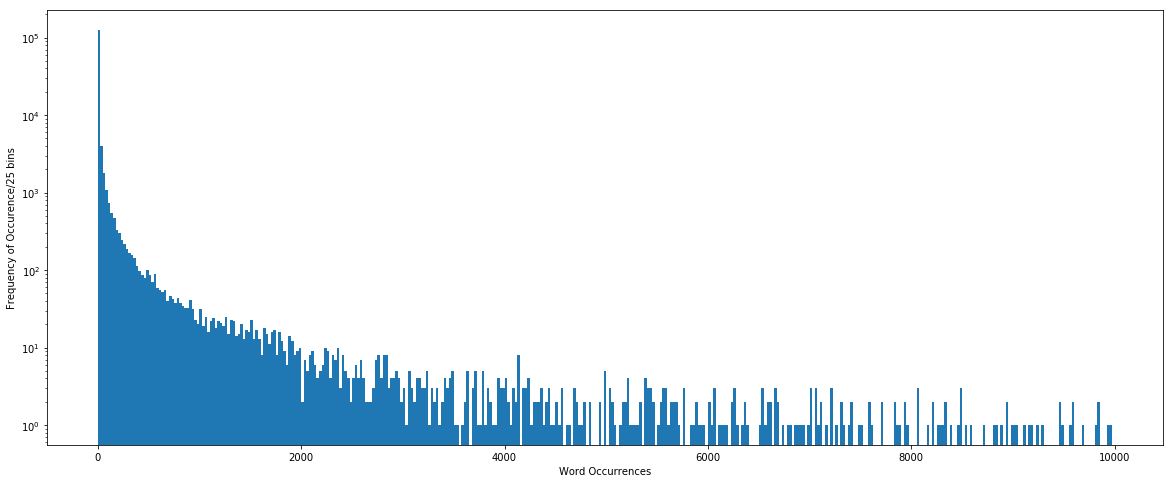

In [18]:
#Plot the histogram of occurrence of tokens
plt.figure(figsize=(20, 8))
plt.hist(df_all_word_counts['word_counts'].values, bins=[i for i in range(1, 10000, 25)], log=True)
plt.xlabel('Word Occurrences')
plt.ylabel('Frequency of Occurence/25 bins')
plt.savefig('WordFrequency.png')

In [19]:
#Check for occurrence of rare words in each sentence and tag sentences where rare words occur

for i in range(0, 20, 1):

    func_length = lambda x: preprocessing.checkWordOccurrenceLength(x, i, word_sets[i])

    df_all['n_' + pair_0 + '_%d_word' % (i+1)] = df_all[pair_0].apply(func_length)

    df_all['n_' + pair_1 + '_%d_word' % (i+1)] = df_all[pair_1].apply(func_length)

In [20]:
#Remove sequence pairs contain rarely occuring words,
rare_word_lower_bound = 10
for i in range(1, rare_word_lower_bound, 1):
    df_all = df_all[
		(df_all['n_' + pair_0 + '_%d_word' % i]==0) &
		(df_all['n_' + pair_1 + '_%d_word' % i]==0)] 

In [21]:
#Merge and create the vocabulary from the sequence pairs
Pair_0_words = set.union(*[set(i) for i in df_all[pair_0].values])

Pair_1_words = set.union(*[set(i) for i in df_all[pair_1].values])

In [22]:
vocab_set = Pair_0_words.union(Pair_1_words)

In [23]:
#We can continue to reduce the vocabulary further by assigning <UNK> tokens to a larger amount of rare tokens but
#preserve the sequences that they arise from as opposed to filtering them completely.
filter_unk = 11
vocab_set_sub = list(set(vocab_set) - set(df_all_word_counts[df_all_word_counts['word_counts']<filter_unk]['word'].values))
#vocab_set_sub = list(set(vocab_set))

In [24]:
print ('vocab size', len(vocab_set), len(vocab_set_sub))

vocab size 21942 20862


In [33]:
def createDict(word, count):
    if word!='<EOS>' or word!='<eos>':
        if word not in vocab_set_sub: return {word : 2}
        else :return {word : count + 3} 
    else:
        return {word:1}

In [34]:
vocab_dict = [createDict(word, word_idx) for word_idx, word in enumerate(vocab_set_sub)]

In [35]:
vocab_dict = {k: v for d in vocab_dict for k, v in d.items()}

In [36]:
vocab_dict['<PAD>'] = 0
vocab_dict['<EOS>'] = 1
vocab_dict['<UNK>'] = 2
vocab_dict['<pad>'] = 0
vocab_dict['<eos>'] = 1
vocab_dict['<unk>'] = 2

In [37]:
print ('size of vocab:%d, size of dataset:%d' % (len(vocab_dict), df_all.shape[0]))

size of vocab:19007, size of dataset:707719


In [38]:
df_final = pd.DataFrame()

In [39]:
encode_sent = lambda x: data_formatting.encodeSent(x, vocab_dict)

In [40]:
df_final['alpha_Pair_1_encoding'] =  df_all[pair_0].apply(encode_sent)
df_final['alpha_Pair_0_encoding'] = df_all[pair_1].apply(encode_sent)

df_final['Index'] = df_all.index.values

In [45]:
df_final.to_pickle(\
    '../processed_data/processed_data_v02_%s_py35_seq_length_%d_%d_sample_%d.pkl' % (dataset, seq_min, seq_max, df_final.shape[0]))

pickle.dump(vocab_dict, \
    open('../processed_data/word_dict_v02_%s_py35_seq_length_%d_%d_sample_%d.pkl' % (dataset, seq_min, seq_max, df_final.shape[0]) , 'wb'))

In [62]:
df_final = pd.read_pickle('../processed_data/processed_data_v02_twitter_py35_seq_length_4_15_sample_707719.pkl')

In [63]:
def nltkCountNGram(n_gram_list):
    flattened_n_gram_list = [i for j in n_gram_list for i in j] 
    df_grams = pd.DataFrame(flattened_n_gram_list, columns=['col_%d' % i for i in range(len(flattened_n_gram_list[0]))]) 
    df_grams['value'] = 1
    columns = df_grams.columns.values
    df_grams_groupby = df_grams.groupby([i for i in columns][:-1])[[i for i in columns][-1]].count().reset_index()
    return df_grams_groupby

In [64]:
#Generate n_grams from anti-lm during decoding
n_grams = []
for n_gram in range(1, 8, 1):
      
    df_n_gram_occurences_1 = Parallel(n_jobs=-1, verbose=8)(\
                delayed(preprocessing.nltkNGram)(text, n_gram) for text in df_final['alpha_Pair_1_encoding'].values)

    df_n_gram_occurences_0 = Parallel(n_jobs=-1, verbose=8)(\
                delayed(preprocessing.nltkNGram)(text, n_gram) for text in df_final['alpha_Pair_0_encoding'].values)
    
    #df_grams = pd.concat([nltkCountNGram(df_n_gram_occurences_1), nltkCountNGram(df_n_gram_occurences_0)])
    df_grams = nltkCountNGram(df_n_gram_occurences_1)
    
    columns = df_grams.columns.values
    df_grams_groupby = df_grams.groupby([i for i in columns][:-1])[[i for i in columns][-1]].sum().reset_index()
    
    n_grams.append(df_grams_groupby.values)

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 28403 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 149433 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 295163 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 422368 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 611138 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 707719 out of 707719 | elapsed:   31.0s finished
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 42637 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 201495 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 391152 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 49975

[Parallel(n_jobs=-1)]: Done 354373 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 467024 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 579675 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 707719 out of 707719 | elapsed:   23.3s finished


In [65]:
pickle.dump(n_grams, open('../processed_data/processed_ngrams_pair_1_counts_v02_%s_py35_seq_length_%d_%d_sample_%d.pkl' % \
                        (dataset, seq_min, seq_max, df_final.shape[0]) , 'wb') )

In [50]:
n_grams = []